# Including Models for Population III Stars

One of the generic results of using [More Realistic Galaxy Populations](example_pop_galaxy) is that they tend to produce strong late-time absorption troughs in the global 21-cm signal (this was the point of [Mirocha, Furlanetto, & Sun (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.464.1365M). Our interpretation was that deviations from these predictions could indicate "new" source populations, like Population III stars and their remnants. Indeed, we found some evidence that such objects introduce asymmetries in the global 21-cm signal (see [Mirocha et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.478.5591M) for details). 

The PopIII stars in this paper are simple, and were designed to seamlessly integrate with *ARES* while capturing the general behavior of more detailed models (e.g., [Mebane, Mirocha, \& Furlanetto (2018)](http://adsabs.harvard.edu/abs/2018MNRAS.479.4544M>). This section will describe how to make use of these models yourself.

The easiest way to tap into these models is via the `ParameterBundle` framework. To begin, the usual imports

In [1]:
%pylab inline
import ares
import numpy as np
import matplotlib.pyplot as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
pars = ares.util.ParameterBundle('mirocha2017:base') \
     + ares.util.ParameterBundle('mirocha2018:high')


##############################################################################################################
####                                           Parameter Bundle                                           ####
##############################################################################################################
#### UPDATE: Setting pop_Tmin{0}          -> None         [previously pop_Tmin{0}          =  1.00e+04]   ####
##############################################################################################################


Parameter bundles are designed to be added together, so as to build-up more complex calculations piece by piece. The above snippet takes the default model from [Mirocha, Furlanetto, & Sun (2017](http://adsabs.harvard.edu/abs/2017MNRAS.464.1365M>) and adds on the default PopIII model from [Mirocha et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.478.5591M>). The "high" suffix refers to the mass of the PopIII stars -- in this case, high means $\sim 100 \ M_{\odot}$. There are also bundles for "low" and "med" mass PopIII stars, which just changes the mass (and resultant spectra) according to the [Schaerer (2002)](http://adsabs.harvard.edu/abs/2002A%26A...382...28S>) models. 

**NOTE:** The ``mirocha2017`` models use some non-standard lookup tables by default. See [Using Data From the Literature](example_litdata) for more info.

You'll notice that while the ``mirocha2017:base`` bundle contains parameters for two source populations -- one that provides the UV emission and another that produces X-rays -- the addition of the PopIII bundle adds two more populations, again one each for UV and X-ray. You can customize the properties of these sources further via the following parameters:

* ``pop_sfr{2}`` 
    The typical star formation rate (SFR) in PopIII halos (in $M_{\odot} \ \mathrm{yr}^{-1}$), in a mass-bin-averaged sense (i.e., we assume PopIII star formation occurs in discrete bursts so the SFR in any individual halo is ill-defined).
* ``pop_time_limit{2}``
    The critical duration of the PopIII phase (in Myr).
* ``pop_bind_limit{2}`` 
    The critical binding energy (in erg) at which point halos transition to PopII star formation.
* ``pop_temp_limit{2}`` 
    The critical virial temperature (in K) at which point halos transition to PopII star formation.
* ``pop_rad_yield{3}``
    The X-ray production efficiency in PopIII halos (in $\mathrm{erg} \ \mathrm{s}^{-1} \ (M_{\odot} \ \mathrm{yr}^{-1})^{-1}$). 

**NOTE:** The duration of PopIII in individual halos will be determined by
    whichever of ``pop_time_limit``, ``pop_bind_limit``, and ``pop_temp_limit`` results in the smallest value (once converted to mass). 
    
**WARNING:** When ``pop_time_limit`` is small ($t \lesssim 20$ Myr) the difference between $M_{\min}$ and $M_{\max}$ approaches a single grid point in the halo mass function lookup table. As a result, the SFRD may suffer from numerical noise, which slows convergence. 
    
It is possible to use a halo mass-dependent prescription for the PopIII SFR if you'd like. In that case, you'll need to update ``pop_sfr_model{2}`` to be ``sfe-func``. See [More Realistic Galaxy Populations](example_pop_galaxy) for a reminder on how to do that.



### Note on Feedback

One of the defining features of PopIII sources is their susceptibility to the global Lyman-Werner (LW) background, which drives up the minimum halo mass for star formation and thus limits the PopIII star formation rate density (SFRD). Because the LW background depends on the SFRD, the introduction of PopIII sources means *ARES* calculations must be performed iteratively. As a result, **you will notice that these models can be quite a bit slower than normal ares calculations (by a factor of a few up to an order of magnitude, typically.**)

There is some control, here, however. If you're not looking for much accuracy, you can change the default set of convergence criteria to accelerate things.

* ``feedback_LW`` 

    If ``False``, LW feedback will be turned off. 
    
* ``feedback_LW_mean_err``

    If ``True``, calculations will terminate as soon as the mean error in :math:`M_{\min}` or the PopIII SFRD satisfy the set tolerances (see next two parameters). By default, it is ``False``.
    
* ``feedback_LW_sfrd_rtol``

    The relative tolerance needed in order for calculations to terminate. By default, this is ``0.05``.
    
* ``feedback_LW_sfrd_atol`` 

    The absolute tolerance needed in order for calculations to terminate. By default, this is ``0.0`` (i.e., unused).
    
* ``feedback_LW_maxiter``

    Maximum number of iterations allowed. By default, 50.
    
* ``feedback_LW_mean_err``

    If ``True``, terminate calculation once *mean* error meets set tolerances. If ``False`` (which is the default), require SFRD and/or $M_{\min}$ to meet tolerance at all redshifts.
    
* ``feedback_LW_mixup_freq``

    Every ``feedback_LW_mixup_freq`` iterations, use average of last two iterations rather than the prediction for the next step. This has been found to help speed-up convergence (see footnote #3 in [the paper](http://adsabs.harvard.edu/abs/2018MNRAS.478.5591M>)).


### Performance Tricks

These models can be quite a bit more expensive than usual due to the iterative nature of the computation. To speed things up, you can run a grid of models and then use that grid to supply initial guesses to the solver for subsequent calculations, which generally reduces the number of iterations required dramatically, especially if the grid is finely sampled.

**NOTE:** For a more detailed intro to model grids, see [Simple Parameter Study: 2-D Model Grid](example_grid).

Let's generate a very sparse grid just to get a feel for how this works.

In [3]:
pars = ares.util.ParameterBundle('mirocha2017:base') \
     + ares.util.ParameterBundle('mirocha2018:high')

pars['feedback_LW'] = True
pars['feedback_LW_maxiter'] = 10
pars['pop_sfr{2}'] = 1e-5
pars['pop_time_limit{2}'] = 100.

# Track the PopII and III SFRDs and Mmin values separately
blobs = ares.util.BlobBundle(**ares.util.ParameterBundle('mirocha2018:csfr_blobs')) 

pars.update(blobs)

# Initialize a ModelGrid object.
mg = ares.inference.ModelGrid(**pars)

# Just vary one parameter for now.
mg.axes = {'pop_time_limit{2}': np.arange(100., 500., 100.)}
           
mg.run('popIII_grid', clobber=True, save_freq=1)

grid: N/A% |                                                                                  | ETA:  --:--:-- 


##############################################################################################################
####                                           Parameter Bundle                                           ####
##############################################################################################################
#### UPDATE: Setting pop_Tmin{0}          -> None         [previously pop_Tmin{0}          =  1.00e+04]   ####
##############################################################################################################
Starting 4-element model grid.
Running 4-element model grid.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# L

grid:  25% |####################                                                              | ETA:   0:25:46 

Checkpoint #1: Thu Aug 26 13:51:19 2021
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalab

grid:  50% |#########################################                                         | ETA:   0:17:02 

Checkpoint #2: Thu Aug 26 13:59:46 2021
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalab

grid:  75% |#############################################################                     | ETA:   0:08:25 

Checkpoint #3: Thu Aug 26 14:08:00 2021
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalab

grid: 100% |##################################################################################| ETA:  00:00:00 

Checkpoint #4: Thu Aug 26 14:14:45 2021


grid: 100% |##################################################################################| Time:  0:32:02 


Processor 0: Wrote popIII_grid.*.pkl (Thu Aug 26 14:14:46 2021)
Calculation complete: Thu Aug 26 14:14:46 2021
Elapsed time (min)  : 32


To speed this up, you could loosen the tolerance, e.g., ``feedback_LW_sfrd_rtol=0.2`` instead of the default ``feedback_LW_sfrd_rtol=0.05``.

**NOTE:** You can enter the above in Python script and invoke with ``mpirun`` if you've got MPI and *mpi4py* installed.


To verify that this grid has run successfully, you could do something like


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : popIII_grid                                                                            ####
#### N-d         : 1                                                                                      ####


(1e-08, 0.01)

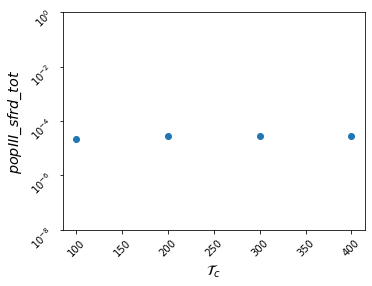

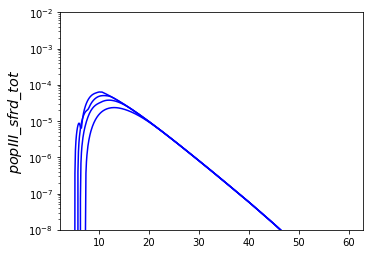

In [4]:
anl = ares.analysis.ModelSet('popIII_grid')

# Plot the time_limit vs. SFRD(z=15)
from ares.physics.Constants import rhodot_cgs
ax1 = anl.Scatter(['pop_time_limit{2}', 'popIII_sfrd_tot'], 
    ivar=[None, 15.], multiplier=[1, rhodot_cgs], fig=1)

ax1.set_yscale('log')
ax1.set_ylim(1e-8, 1)

# Just show all the PopIII SFRDs
ax2 = anl.ReconstructedFunction('popIII_sfrd_tot', samples='all', color='b', fig=2, multiplier=[rhodot_cgs])
ax2.set_yscale('log')
ax2.set_ylim(1e-8, 1e-2)

Now, to use this model grid for further calculations, you can simply do:

In [5]:
pars = ares.util.ParameterBundle('mirocha2017:base') \
     + ares.util.ParameterBundle('mirocha2018:high')

# Choose a value not represented in the grid.
pars['pop_time_limit{2}'] = 150.

# These are new!
pars['feedback_LW_guesses'] = 'popIII_grid'
pars['feedback_LW_guesses_from'] = ['pop_time_limit'] # no ID number needed
    
sim = ares.simulations.Global21cm(**pars)
sim.run()


##############################################################################################################
####                                           Parameter Bundle                                           ####
##############################################################################################################
#### UPDATE: Setting pop_Tmin{0}          -> None         [previously pop_Tmin{0}          =  1.00e+04]   ####
##############################################################################################################
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.

##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### --------------------------------------

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020
# WARNING: revisit scalability wrt fesc.
# WARNING: revisit scalability wrt fesc.
# Loaded /Users/jordanmirocha/Dropbox/work/mods/ares/input/optical_depth/optical_depth_planck_TTTEEE_lowl_lowE_best_He_1000x2158_z_5-60_logE_2.3-4.5.hdf5.
# Loaded /Users/jordanmirocha/Dropbox/work/mods/ares/input/optical_depth/optical_depth_planck_TTTEEE_lowl_lowE_best_He_1000x2158_z_5-60_logE_2.3-4.5.hdf5.
# LWB cycle #5 complete: mean_err=1.92e-03, max_err=9.91e-01, z(max_err)=6.8
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020
# WARNING: revisit scalability wrt fesc.
#

gs-21cm: 100% |###############################################################################| Time:  0:00:02 


*ARES* will initialize a ``ModelGrid`` object using the ``popIII_grid*`` files in the current working directory. Importantly, we've told *ARES* to use the parameter ``pop_time_limit`` to set initial guesses, which seems obvious here but in general we could have more parameters in the grid and we could opt to only use a subset here.

If all goes according to plan, *ARES* will use the ``pop_time_limit{2}=10`` grid point, pulling the result for the minimum mass evolution (which we saved as a blob) and using it as the initial guess. This should result in a SFRD very similar, but not identical to, the ``pop_time_limit{2}=10`` model in our grid. And, most importantly, whereas the ``pop_time_limit{2}=10`` model took 20 iterations to complete, the ``pop_time_limit{2}=12'' model should only take 10 (with default tolerances).

This kind of thing can be very useful if you want to vary parameters that do not affect the PopIII SFRD. In fact this is precisely what we did in `Mirocha et al. (2018) <http://adsabs.harvard.edu/abs/2018MNRAS.478.5591M>`_. In this case, we knew ahead of time that we would only survey the *exact* models represented in the grid, so we set:

In [6]:
pars['feedback_LW_guesses_perfect'] = True

which told *ARES* not just to use results from the ``ModelGrid`` as first guesses, but to assume they are perfect, in which case no further iteration by the solver is required.